In [1]:
import tkinter as tk
from tkinter import filedialog
import os
import numpy as np
import re
from sklearn.metrics import mean_squared_error
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv1D, MaxPooling1D, UpSampling1D, Conv1DTranspose, ZeroPadding1D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
import pandas as pd
import matplotlib.pyplot as plt
import gc
import pickle

In [2]:
# 符号付に変換する関数
def unsigned2signed(x):
    if x > 32767:
        return x - 65536
    return x

In [3]:
# 学習データの読み込み
def load_binary_data(folder_path):
    data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in data or data_index > data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    file_names.append(file_name)  # ファイル名をリストに追加

    return data, file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# フォルダを選択するためのダイアログを表示
folder_selected = filedialog.askdirectory()

if folder_selected:
    print("選択したフォルダ:", folder_selected)
    # フォルダ内のデータを読み込む
    data, data_filenames = load_binary_data(folder_selected)
    if data:
        print("データの読み込みが完了しました。")
    else:
        print("データが見つかりませんでした。")
else:
    print("フォルダが選択されませんでした。")

# Tkinterを終了
root.quit()


sensor_data_dict = {}  # センサーデータを格納するディクショナリ
for key, sensor_data in data.items():
    extension_number = sensor_data[-1]  # 拡張子の番号
    for i, sensor_value in enumerate(sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if sensor_key not in sensor_data_dict:
            sensor_data_dict[sensor_key] = []  # キーが存在しない場合、空のリストを作成
        sensor_data_dict[sensor_key].append(sensor_value)  # キーに対応するリストにセンサーデータを追加

# データの形状を決定
num_samples = len(sensor_data_dict)
num_sensors = 8  # センサーの数

# 2次元のリストを初期化
data_matrix = [[None] * num_sensors for _ in range(num_samples)]

# センサーデータのみを保存する新しい変数を作成
sensor_data = []

# データを2次元リストと新しい変数に配置
for i, (key, sensor_values) in enumerate(sensor_data_dict.items()):
    data_matrix[i] = [key] + sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    sensor_data.append(sensor_values)  # センサーデータのリストを新しい変数に格納
    
# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in sensor_data:
    for sensor_values in sample:
        reshaped_sensor_data.append(sensor_values)

sensor_data = reshaped_sensor_data

# センサーデータをDataFrameに変換
df = pd.DataFrame(sensor_data)

# キーのリストをpickleファイルに保存
pickle_file_path = "sensor_keys.pkl"
keys_list = list(sensor_data_dict.keys())

with open(pickle_file_path, 'wb') as f:
    pickle.dump(keys_list, f)

print("キーのリストをpickleファイルに保存しました。ファイルパス:", pickle_file_path)

# DataFrameをローカルに保存
pickle_file_path = "sensor_data.pkl"
df.to_pickle(pickle_file_path)

print("DataFrameをローカルに保存しました。ファイルパス:", pickle_file_path)

del sensor_value, sensor_values,reshaped_sensor_data, data_matrix, data_filenames, sensor_data_dict, df

選択したフォルダ: C:/Users/r-fujita/Desktop/20240307/train
データの読み込みが完了しました。
キーのリストをpickleファイルに保存しました。ファイルパス: sensor_keys.pkl
DataFrameをローカルに保存しました。ファイルパス: sensor_data.pkl


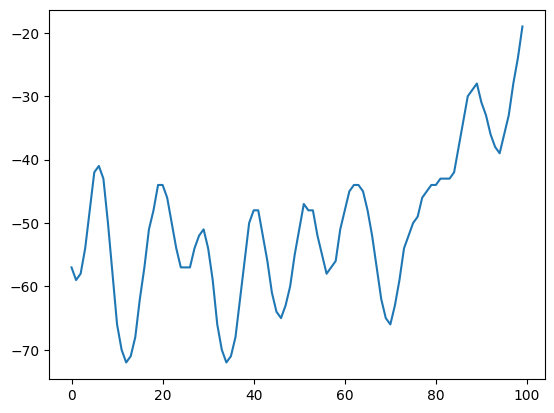

In [17]:
plt.plot(sensor_data[0][8400:8500])

In [4]:
# テストデータの読み込み
def load_test_data(test_folder_path):
    test_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    test_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(test_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in test_data or data_index > test_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    test_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    test_file_names.append(file_name)  # ファイル名をリストに追加

    return test_data, test_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# テストデータのフォルダを選択するためのダイアログを表示
test_folder_path = filedialog.askdirectory()

if test_folder_path:
    print("選択したテストデータのフォルダ:", test_folder_path)
    # テストデータを読み込む
    test_data, test_data_filenames = load_test_data(test_folder_path)
    if test_data:
        print("テストデータの読み込みが完了しました。")
    else:
        print("テストデータが見つかりませんでした.")
else:
    print("テストデータのフォルダが選択されませんでした.")

test_sensor_data_dict = {}  # テストデータのセンサーデータを格納するディクショナリ
for key, test_sensor_data in test_data.items():
    extension_number = test_sensor_data[-1]  # 拡張子の番号
    for i, test_sensor_value in enumerate(test_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        test_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if test_sensor_key not in test_sensor_data_dict:
            test_sensor_data_dict[test_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        test_sensor_data_dict[test_sensor_key].append(test_sensor_value)  # キーに対応するリストにテストデータのセンサーデータを追加

# データの形状を決定
num_test_samples = len(test_sensor_data_dict)
num_sensors = 8  # センサーの数

# テストデータの2次元のリストを初期化
test_data_matrix = [[None] * num_sensors for _ in range(num_test_samples)]

# テストデータのセンサーデータのみを保存する新しい変数を作成
test_sensor_data = []

# テストデータを2次元リストと新しい変数に配置
for i, (key, test_sensor_values) in enumerate(test_sensor_data_dict.items()):
    test_data_matrix[i] = [key] + test_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    test_sensor_data.append(test_sensor_values)  # テストデータのセンサーデータのリストを新しい変数に格納

# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in test_sensor_data:
    for test_sensor_values in sample:
        reshaped_sensor_data.append(test_sensor_values)

test_sensor_data = reshaped_sensor_data

del test_sensor_value, test_sensor_values,reshaped_sensor_data

選択したテストデータのフォルダ: C:/Users/r-fujita/Desktop/20240307/test
テストデータの読み込みが完了しました。


In [5]:
# 検証用データの読み込み
def load_val_data(val_folder_path):
    val_data = {}  # ファイルの拡張子と数字を除いたフルパスをキーとしたディクショナリ
    val_file_names = []  # ファイル名を格納するリスト

    for root, dirs, files in os.walk(val_folder_path):
        for file in files:
            match = re.match(r'(.+?)\.d(\d+)', file)  # 正規表現で.d○○の形式のファイル名を捉える
            if match:
                file_name, data_index = match.groups()
                data_index = int(data_index)
                full_path = os.path.join(root, file)  # フルパス
                full_path_key = full_path[:-4]  # 拡張子と数字を除いたフルパス
                if full_path_key not in val_data or data_index > val_data[full_path_key][8]:
                    with open(full_path, 'rb') as in_file:
                        buf = in_file.read()
                    # 8つのセンサーデータをグループ化
                    sensor_data = [buf[i:i+8*2] for i in range(408, len(buf), 8*2)]
                    sensor_values = []  # センサーデータを格納するリスト
                    for i in range(8):
                        sensor_values.append([unsigned2signed(int.from_bytes(sensor[i*2:i*2+2], 'little')) for sensor in sensor_data])
                    # 拡張子の番号を追加してデータをタプルに格納
                    sensor_values.append(int(data_index))
                    val_data[full_path_key] = sensor_values  # センサーデータと拡張子の番号をタプルに格納
                    val_file_names.append(file_name)  # ファイル名をリストに追加

    return val_data, val_file_names

# Tkinterを初期化
root = tk.Tk()
root.withdraw()  # メインウィンドウを非表示にする

# 検証データのフォルダを選択するためのダイアログを表示
val_folder_path = filedialog.askdirectory()

if val_folder_path:
    print("選択した検証データのフォルダ:", val_folder_path)
    # 検証データを読み込む
    val_data, val_data_filenames = load_val_data(val_folder_path)
    if val_data:
        print("検証データの読み込みが完了しました。")
    else:
        print("検証データが見つかりませんでした.")
else:
    print("検証データのフォルダが選択されませんでした.")

val_sensor_data_dict = {}  # 検証データのセンサーデータを格納するディクショナリ
for key, val_sensor_data in val_data.items():
    extension_number = val_sensor_data[-1]  # 拡張子の番号
    for i, val_sensor_value in enumerate(val_sensor_data[:-1]):  # 拡張子の番号を除くセンサーデータをループ
        val_sensor_key = f"{key}_{extension_number}_{i+1}"  # キーを生成
        if val_sensor_key not in val_sensor_data_dict:
            val_sensor_data_dict[val_sensor_key] = []  # キーが存在しない場合、空のリストを作成
        val_sensor_data_dict[val_sensor_key].append(val_sensor_value)  # キーに対応するリストに検証データのセンサーデータを追加

# データの形状を決定
num_val_samples = len(val_sensor_data_dict)
num_sensors = 8  # センサーの数

# 検証データの2次元のリストを初期化
val_data_matrix = [[None] * num_sensors for _ in range(num_val_samples)]

# 検証データのセンサーデータのみを保存する新しい変数を作成
val_sensor_data = []

# 検証データを2次元リストと新しい変数に配置
for i, (key, val_sensor_values) in enumerate(val_sensor_data_dict.items()):
    val_data_matrix[i] = [key] + val_sensor_values  # キーとセンサーデータのリストを1つのリストに格納
    val_sensor_data.append(val_sensor_values)  # 検証データのセンサーデータのリストを新しい変数に格納

# 3次元のリストを2次元のリストに変換する
reshaped_sensor_data = []
for sample in val_sensor_data:
    for val_sensor_values in sample:
        reshaped_sensor_data.append(val_sensor_values)

val_sensor_data = reshaped_sensor_data
del val_sensor_value, val_sensor_values,reshaped_sensor_data

選択した検証データのフォルダ: C:/Users/r-fujita/Desktop/20240307/val
検証データの読み込みが完了しました。


In [6]:
del data, data_filenames,data_matrix, i, num_samples, num_sensors, num_test_samples, num_val_samples, test_folder_path, test_sensor_key
del test_data, test_data_filenames, test_data_matrix, val_data, val_data_filenames, val_data_matrix, val_folder_path, val_sensor_key

In [11]:
# メモリ解放
gc.collect()

0

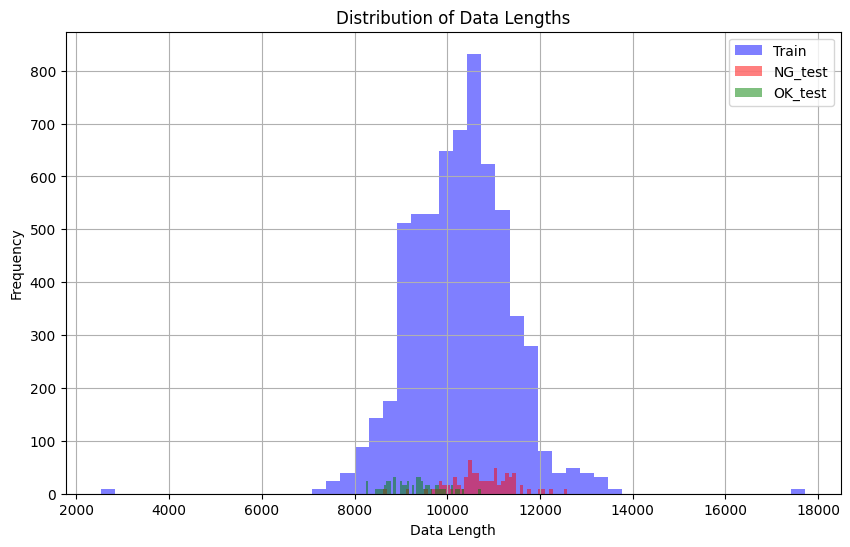

In [6]:
# データ長を取得
sensor_data_lengths = [len(data) for data in sensor_data]
test_sensor_data_lengths = [len(data) for data in test_sensor_data]
val_sensor_data_lengths = [len(data) for data in val_sensor_data]
# ヒストグラムをプロット
plt.figure(figsize=(10, 6))
plt.hist(sensor_data_lengths, bins=50, alpha=0.5, color='blue', label='Train')
plt.hist(test_sensor_data_lengths, bins=50, alpha=0.5, color='red', label='NG_test')
plt.hist(val_sensor_data_lengths, bins=50, alpha=0.5, color='green', label='OK_test')
plt.xlabel('Data Length')
plt.ylabel('Frequency')
plt.title('Distribution of Data Lengths')
plt.legend()
plt.grid(True)
plt.show()

In [7]:
# データ長が4000未満及び15000以上のデータを削除する。

# 学習データ
# データ長が15000以上のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(sensor_data) if len(data) >= 15000]
# 対応するインデックスのデータを削除する
for index in sorted(indices_to_remove, reverse=True):
    del sensor_data[index]
# データ長が4000未満のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(sensor_data) if len(data) < 5000]
for index in sorted(indices_to_remove, reverse=True):
    del sensor_data[index]

# テストデータ
# データ長が15000以上のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(test_sensor_data) if len(data) >= 15000]
# 対応するインデックスのデータを削除する
for index in sorted(indices_to_remove, reverse=True):
    del test_sensor_data[index]
# データ長が4000未満のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(test_sensor_data) if len(data) < 5000]
for index in sorted(indices_to_remove, reverse=True):
    del test_sensor_data[index]

# 検証データ
# データ長が15000以上のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(val_sensor_data) if len(data) >= 15000]
# 対応するインデックスのデータを削除する
for index in sorted(indices_to_remove, reverse=True):
    del val_sensor_data[index]
# データ長が4000未満のデータのインデックスを取得する
indices_to_remove = [index for index, data in enumerate(val_sensor_data) if len(data) < 5000]
for index in sorted(indices_to_remove, reverse=True):
    del val_sensor_data[index]

In [8]:
# データの標準化
# 学習データ
sensor_data_sca = []
for i in range(len(sensor_data)):
    mean = np.mean(sensor_data[i])
    std = np.std(sensor_data[i])

    #標準化処理を実行
    standardization_sensor_data = (sensor_data[i] - mean) / std
    sensor_data_sca.append(standardization_sensor_data)
    
del sensor_data, standardization_sensor_data

# テストデータ
test_sensor_data_sca = []
for i in range(len(test_sensor_data)):
    mean = np.mean(test_sensor_data[i])
    std = np.std(test_sensor_data[i])

    #標準化処理を実行
    standardization_test_sensor_data = (test_sensor_data[i] - mean) / std
    test_sensor_data_sca.append(standardization_test_sensor_data)

del test_sensor_data, standardization_test_sensor_data

# 検証データ
val_sensor_data_sca = []
for i in range(len(val_sensor_data)):
    mean = np.mean(val_sensor_data[i])
    std = np.std(val_sensor_data[i])

    #標準化処理を実行
    standardization_val_sensor_data = (val_sensor_data[i] - mean) / std
    val_sensor_data_sca.append(standardization_val_sensor_data)
    
del val_sensor_data, standardization_val_sensor_data  

# データ長を揃える(最長のデータ+999)
# 最大の波形データ長を見つける
max_length = max(len(data) for data in sensor_data_sca + test_sensor_data_sca + val_sensor_data_sca)
max_length = max_length+1000

# ゼロパディングを行う（学習データ）
padded_sensor_data = []
for data in sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_sensor_data.append(padded_data)
    
del padded_data, sensor_data_sca

# ゼロパディングを行う（テストデータ）
padded_test_sensor_data = []
for data in test_sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_test_sensor_data.append(padded_data)
    
del padded_data, test_sensor_data_sca


# ゼロパディングを行う（検証データ）
padded_val_sensor_data = []
for data in val_sensor_data_sca:
    padding_length = max_length - len(data)
    padding_beginning = padding_length // 2
    padding_end = padding_length - padding_beginning
    padded_data = np.pad(data, (padding_beginning, padding_end), mode='constant', constant_values=0)
    padded_val_sensor_data.append(padded_data)

del padded_data, val_sensor_data_sca


# 学習データとテストデータをNumPyの配列に変換
padded_sensor_data = np.array(padded_sensor_data)
padded_test_sensor_data = np.array(padded_test_sensor_data)
padded_val_sensor_data = np.array(padded_val_sensor_data)


# チャンネル毎にデータを結合(学習データ)
ch = 8
concatenated_data_per_subject = []
for i in range(len(padded_sensor_data) // ch):  # 管の数だけループ
    subject_data = padded_sensor_data[i * ch:(i + 1) * ch]  # 同じ管のチャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_sensor_data.append(data.reshape(-1, ch))  # データ長×チャンネルの形状に変換し、リストに追加

reshaped_sensor_data = np.array(reshaped_sensor_data)  # リストをNumPy配列に変換


# チャンネル毎にデータを結合(テストデータ)
concatenated_data_per_subject = []
for i in range(len(padded_test_sensor_data) // ch):  # 管の数だけループ
    subject_data = padded_test_sensor_data[i * ch:(i + 1) * ch]  # 同じ管のチャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)


# データをデータ長×8チャンネルの形状に整形する
reshaped_test_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_test_sensor_data.append(data.reshape(-1, ch))  # データ長×チャンネルの形状に変換し、リストに追加

reshaped_test_sensor_data = np.array(reshaped_test_sensor_data)  # リストをNumPy配列に変換


# チャンネル毎にデータを結合(検証データ)
concatenated_data_per_subject = []
for i in range(len(padded_val_sensor_data) // ch):  # 管の数だけループ
    subject_data = padded_val_sensor_data[i * ch:(i + 1) * ch]  # 同じ管のチャンネルのデータを取得
    concatenated_data = np.stack(subject_data, axis=-1)  # チャンネルのデータを1つの配列に連結
    concatenated_data_per_subject.append(concatenated_data)

# データをデータ長×8チャンネルの形状に整形する
reshaped_val_sensor_data = []
for data in concatenated_data_per_subject:
    reshaped_val_sensor_data.append(data.reshape(-1, ch))  # データ長×チャンネルの形状に変換し、リストに追加

reshaped_val_sensor_data = np.array(reshaped_val_sensor_data)  # リストをNumPy配列に変換
del padded_sensor_data, padded_test_sensor_data, padded_val_sensor_data, data, concatenated_data

In [9]:
def stacked_what_where_autoencoder(input_shape):
    # Encoder
    inputs = Input(shape=input_shape)
    conv1 = Conv1D(32, 10, activation='selu', padding='same')(inputs)
    pool1 = MaxPooling1D(pool_size=2, padding='same')(conv1)  
    conv2 = Conv1D(64, 5, activation='selu', padding='same')(pool1)
    pool2 = MaxPooling1D(pool_size=2, padding='same')(conv2)  

    # Decoder
    conv3 = Conv1DTranspose(64, 5, strides=2, activation='selu', padding='same')(pool2)
    conv4 = Conv1DTranspose(32, 10, strides=2, activation='selu', padding='same')(conv3)
    decoded = Conv1DTranspose(input_shape[-1], 7, padding='same')(conv4)  # 出力形状を入力形状と一致させる

    # Autoencoder Model
    autoencoder = Model(inputs, decoded)
    return autoencoder

In [19]:
# 入力データの形状を取得
input_shape = reshaped_sensor_data.shape[1:]

# Stacked What-Where Autoencoderを構築
autoencoder = stacked_what_where_autoencoder(input_shape)
autoencoder.compile(optimizer='adam', loss='mean_squared_error')

# モデルのサマリを表示
autoencoder.summary()

# モデルの学習
history = autoencoder.fit(reshaped_sensor_data, reshaped_sensor_data, epochs=100, batch_size=8, shuffle=True, verbose=1)

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 14648, 8)]        0         
                                                                 
 conv1d_2 (Conv1D)           (None, 14648, 32)         2592      
                                                                 
 max_pooling1d_2 (MaxPooling  (None, 7324, 32)         0         
 1D)                                                             
                                                                 
 conv1d_3 (Conv1D)           (None, 7324, 64)          10304     
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 3662, 64)         0         
 1D)                                                             
                                                                 
 conv1d_transpose_3 (Conv1DT  (None, 7324, 64)         2054

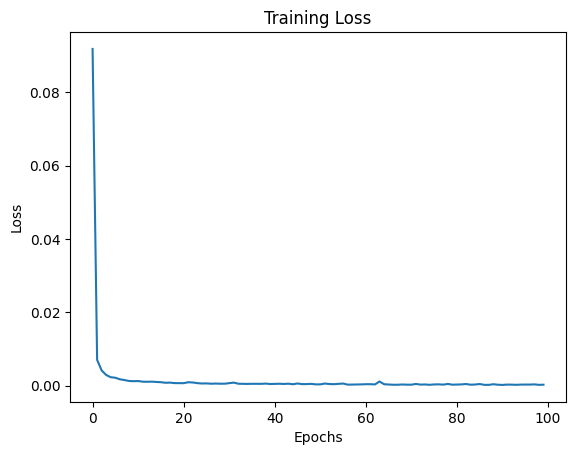

In [11]:
# 損失関数の値を取得
loss = history.history['loss']

# エポックごとの損失関数の変化をプロット
plt.plot(loss)
plt.title('Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.show()

In [20]:
from matplotlib.ticker import FuncFormatter

In [51]:
# テストデータの再構築を行い再構成誤差を計算する
reconstructed_data = autoencoder.predict(reshaped_sensor_data)
mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=(1, 2))

25/25 [==============================] - 0s 16ms/step


In [50]:
# テストデータの再構築を行い再構成誤差を計算する
reconstructed_test_data = autoencoder.predict(reshaped_test_sensor_data)
mse_test = np.mean(np.square(reshaped_test_sensor_data - reconstructed_test_data), axis=(1, 2))

3/3 [==============================] - 0s 10ms/step


In [16]:
# 学習データの再構成を行い再構成誤差を計算する
# reconstructed_data = autoencoder.predict(reshaped_sensor_data)
# mse = np.mean(np.square(reshaped_sensor_data - reconstructed_data), axis=(1, 2))

In [49]:
# 検証データの再構築を行い再構成誤差を計算する
reconstructed_val_data = autoencoder.predict(reshaped_val_sensor_data)
mse_val = np.mean(np.square(reshaped_val_sensor_data - reconstructed_val_data), axis=(1, 2))

2/2 [==============================] - 0s 159ms/step


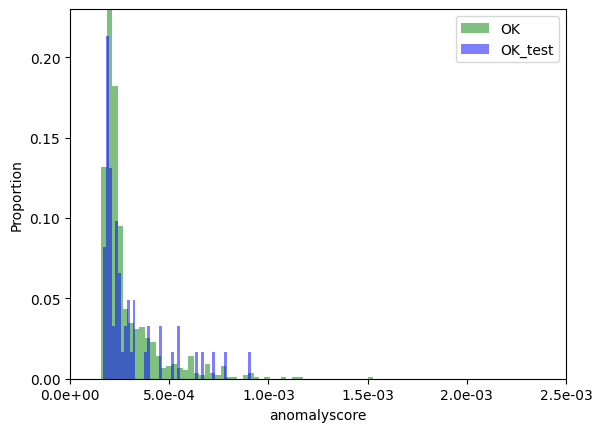

In [24]:
# ヒストグラムの作成
weights1 = np.ones(len(mse))/float(len(mse))
weights2 = np.ones(len(mse_test))/float(len(mse_test))
weights3 = np.ones(len(mse_val))/float(len(mse_val))
plt.hist(mse, bins=50, alpha=0.5, label='OK',weights=weights1, color='green')  # 学習データのヒストグラムをプロット
#plt.hist(mse_test, bins=50, alpha=0.5, label='test', weights=weights2)  # テストデータのヒストグラムをプロット
plt.hist(mse_val, bins=50, alpha=0.5, label='OK_test', weights=weights3, color='blue')  # 検証データのヒストグラムをプロット
plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
plt.xlim(0,0.0025)
plt.ylim(0,0.23)
formatter = FuncFormatter(lambda x, _: f'{x:.1e}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()  # 凡例を表示
plt.show()

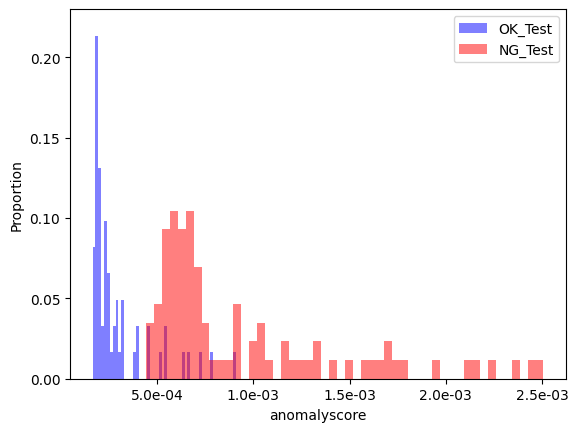

In [25]:
# ヒストグラムの作成（割合）
plt.hist(mse_val, bins=50, alpha=0.5, label='OK_Test', weights=weights3, color='blue')  # 検証データのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='NG_Test', weights=weights2, color='red')  # テストデータのヒストグラムをプロット
plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
#plt.xlim(0,0.001)
plt.ylim(0,0.23)
formatter = FuncFormatter(lambda x, _: f'{x:.1e}')
plt.gca().xaxis.set_major_formatter(formatter)
plt.legend()  # 凡例を表示
plt.show()

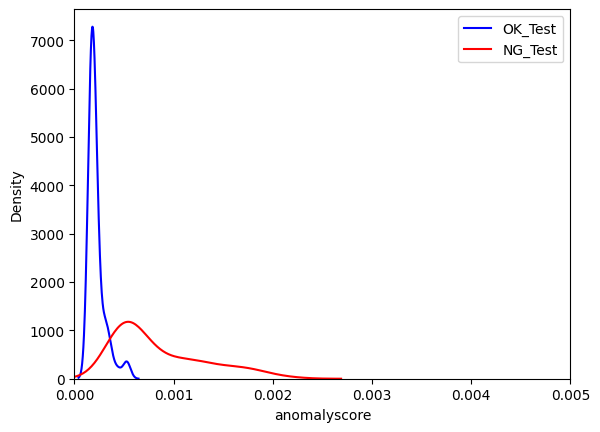

In [19]:
import seaborn as sns

# KDEプロットを作成
sns.kdeplot(mse_val, label='OK_Test', color='blue')
sns.kdeplot(mse_test, label='NG_Test', color='red')

# x軸とy軸のラベルを設定
plt.xlabel('anomalyscore')
plt.ylabel('Density')

# x軸の表示範囲を設定
plt.xlim(0, 0.005)

# 凡例を表示
plt.legend()

# グラフを表示
plt.show()


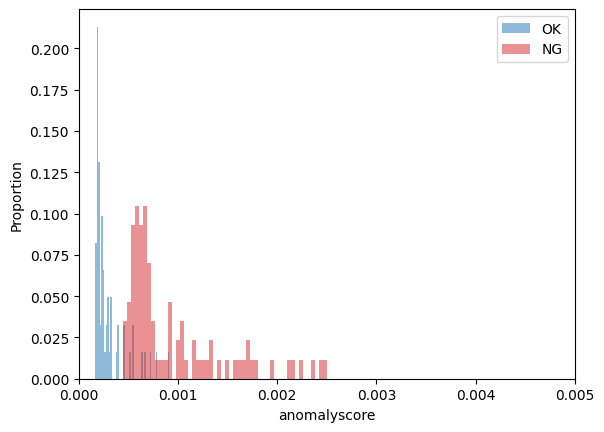

In [26]:
weights2 = np.ones(len(mse_test))/float(len(mse_test))
weights3 = np.ones(len(mse_val))/float(len(mse_val))

# プロットに使用する色を定義
color_ok = 'tab:blue'  # 検証データの色
color_ng = 'tab:red'   # テストデータの色

plt.hist(mse_val, bins=50, alpha=0.5, label='OK', weights=weights3, color=color_ok)  # 検証データのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='NG', weights=weights2, color=color_ng)  # テストデータのヒストグラムをプロット

plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
plt.xlim(0, 0.005)
plt.legend()

# グラフを保存
plt.savefig('histogram_gray_identifiable.jpg', dpi=300, bbox_inches='tight')

plt.show()

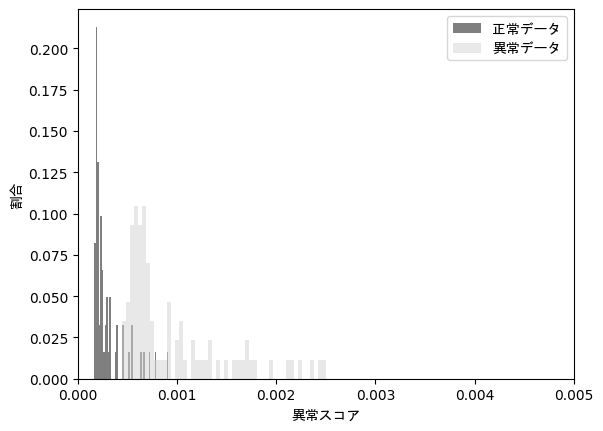

In [47]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# 日本語フォントの設定
path = 'C:\Windows\Fonts\msgothic.ttc'  # IPAexゴシックのパス（システムに応じて変更してください）
prop = fm.FontProperties(fname=path)

# 重みの定義
weights2 = np.ones(len(mse_test)) / float(len(mse_test))
weights3 = np.ones(len(mse_val)) / float(len(mse_val))

# グラフに使用する色（グレースケール）
color_ok = 'black'  # 検証データの色
color_ng = 'lightgray'  # テストデータの色

# 検証データのヒストグラムをプロット
plt.hist(mse_val, bins=50, alpha=0.5, label='正常データ', weights=weights3, color=color_ok)

# テストデータのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='異常データ', weights=weights2, color=color_ng)

plt.xlabel('再構成誤差', fontproperties=prop)
plt.ylabel('割合(%)', fontproperties=prop)
plt.xlim(0, 0.005)
plt.legend(prop=prop)

# グラフを保存
plt.savefig('histogram_gray_identifiable.jpg', dpi=300, bbox_inches='tight')

plt.show()

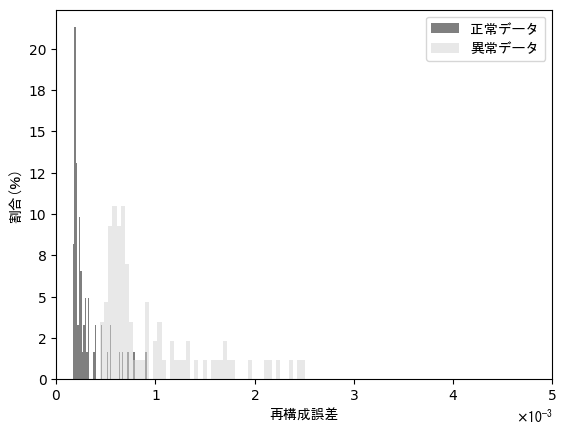

In [54]:
from matplotlib.ticker import FuncFormatter, ScalarFormatter

# 日本語フォントの設定
path = 'C:\\Windows\\Fonts\\msgothic.ttc'  # IPAexゴシックのパス（システムに応じて変更してください）
prop = fm.FontProperties(fname=path)


# 重みの定義
weights2 = np.ones(len(mse_test)) / float(len(mse_test))
weights3 = np.ones(len(mse_val)) / float(len(mse_val))

# グラフに使用する色（グレースケール）
color_ok = 'black'  # 検証データの色
color_ng = 'lightgray'  # テストデータの色

# 検証データのヒストグラムをプロット
plt.hist(mse_val, bins=50, alpha=0.5, label='正常データ', weights=weights3, color=color_ok)

# テストデータのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='異常データ', weights=weights2, color=color_ng)

# 縦軸を割合（%）にするためのフォーマッター
def to_percent(y, position):
    return f'{100 * y:.0f}'

plt.gca().yaxis.set_major_formatter(FuncFormatter(to_percent))

# 横軸をべき乗（科学）表記にするためのフォーマッター
plt.gca().xaxis.set_major_formatter(ScalarFormatter(useMathText=True))
plt.gca().xaxis.get_offset_text().set_font_properties(prop)
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))

plt.xlabel('再構成誤差', fontproperties=prop)
plt.ylabel('割合(％)', fontproperties=prop)
plt.xlim(0, 0.005)
plt.legend(prop=prop)

# グラフを保存
plt.savefig('histogram_gray_identifiable.jpg', dpi=300, bbox_inches='tight')

plt.show()

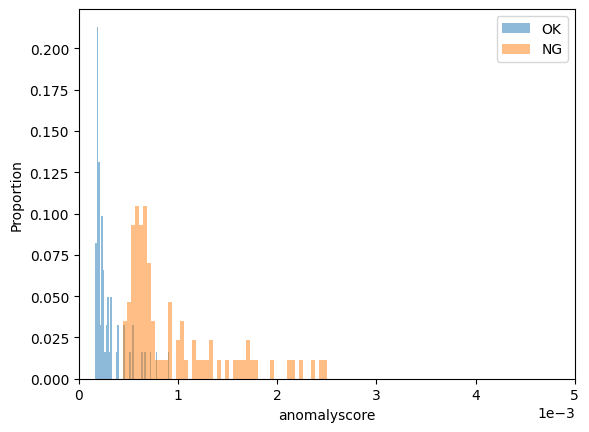

In [27]:
# グラフの背景色を白に設定
plt.rcParams['figure.facecolor'] = 'white'

weights2 = np.ones(len(mse_test))/float(len(mse_test))
weights3 = np.ones(len(mse_val))/float(len(mse_val))

plt.hist(mse_val, bins=50, alpha=0.5, label='OK', weights=weights3)  # 検証データのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='NG', weights=weights2)  # テストデータのヒストグラムをプロット

plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
plt.xlim(0, 0.005)

# 横軸の指数表示に変更
plt.ticklabel_format(style='sci', axis='x', scilimits=(0,0))
plt.legend()

# グラフをJPEG形式で保存
plt.savefig('histogram_gray_white_background.jpg', dpi=300)

plt.show()

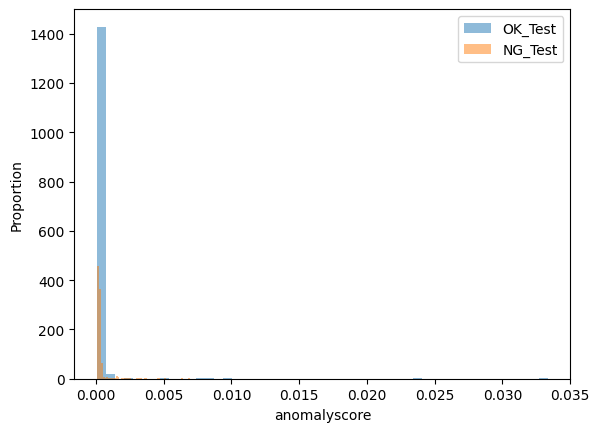

In [20]:
# ヒストグラムの作成（度数）
weights2 = np.ones(len(mse_test))/float(len(mse_test))
weights3 = np.ones(len(mse_val))/float(len(mse_val))
plt.hist(mse_val, bins=50, alpha=0.5, label='OK_Test')  # 検証データのヒストグラムをプロット
plt.hist(mse_test, bins=50, alpha=0.5, label='NG_Test')  # テストデータのヒストグラムをプロット
plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
plt.legend()  # 凡例を表示
plt.show()

In [119]:
threshold = 0.00027  # しきい値を設定

# mse_testをしきい値で分類する
classified_test = ['OK' if mse <= threshold else 'NG' for mse in mse_test]

# mse_valをしきい値で分類する
classified_val = ['OK' if mse <= threshold else 'NG' for mse in mse_val]

# mse_testをしきい値で分類してOKとNGの数をカウントする
ok_count_test = sum(1 for mse in mse_test if mse <= threshold)
ng_count_test = len(mse_test) - ok_count_test

# mse_valをしきい値で分類してOKとNGの数をカウントする
ok_count_val = sum(1 for mse in mse_val if mse <= threshold)
ng_count_val = len(mse_val) - ok_count_val

# 結果を出力
print("テストデータ: OK =", ok_count_test, "NG =", ng_count_test)
print("検証データ: OK =", ok_count_val, "NG =", ng_count_val)

テストデータ: OK = 0 NG = 86
検証データ: OK = 46 NG = 15


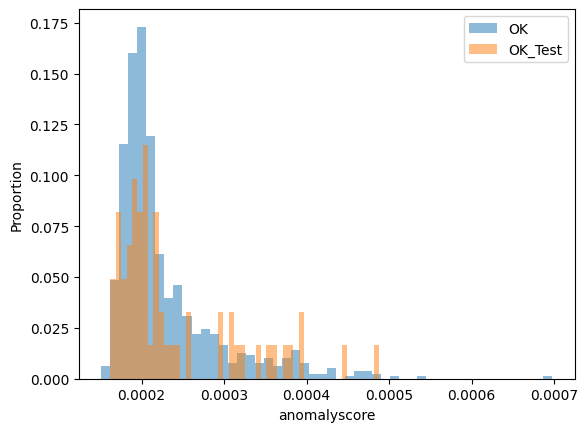

In [73]:
plt.hist(mse, bins=50, alpha=0.5, label='OK', weights=weights1)  # テストデータのヒストグラムをプロット
plt.hist(mse_val, bins=50, alpha=0.5, label='OK_Test', weights=weights3)  # 検証データのヒストグラムをプロット
plt.xlabel('anomalyscore')
plt.ylabel('Proportion')
plt.legend()  # 凡例を表示
plt.show()

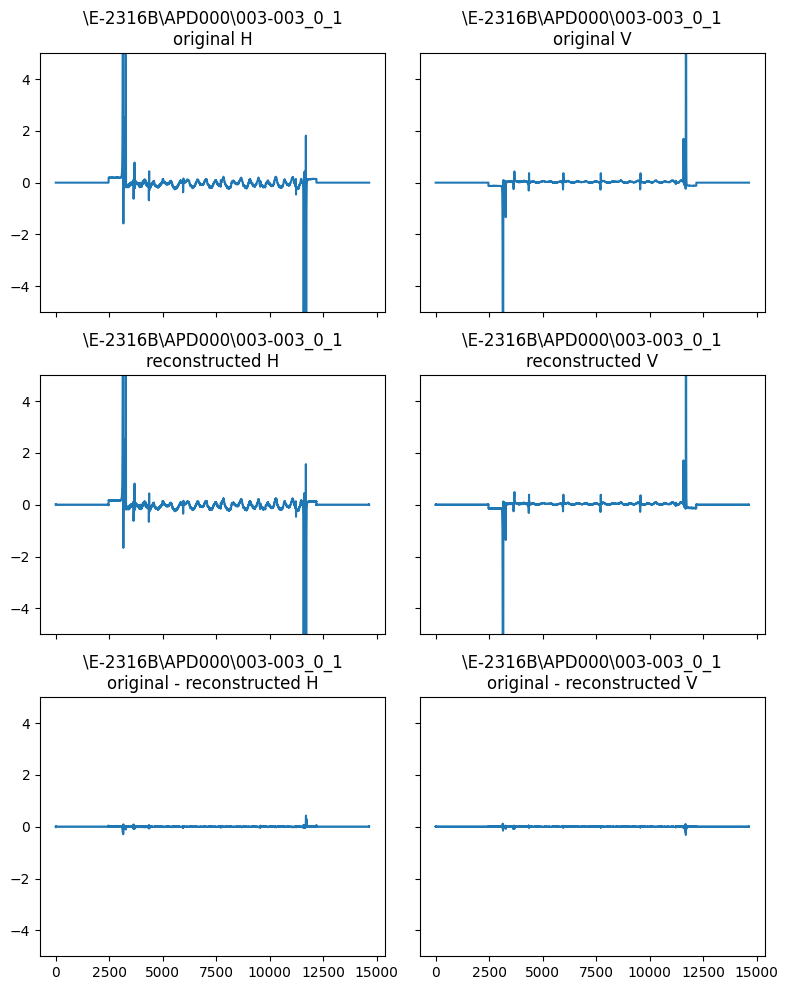

In [111]:
# 学習データをプロット
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)

ch = 2 # F1=0, F2=2, F3=4, MIX=6
H = ch 
V = ch+1
n = 0

# オリジナルのセンサーデータのキーを取得
data_key = list(sensor_data_dict.keys())[n*8]
# キーから重要な情報を抜き出す（例: データの種類や位置）
info = data_key.split('ASSORT')[1]

# 上段左のサブプロットにプロットする
axes[0,0].plot(reshaped_sensor_data[n,:,H])
axes[0,0].set_title(f'{info}\noriginal H')
plt.ylim(-5,5)
# 中段左のサブプロットにプロットする
axes[1,0].plot(reconstructed_data[n,:,H])
axes[1,0].set_title(f'{info}\nreconstructed H')
# 下段左のサブプロットにプロットする
axes[2,0].plot(reshaped_sensor_data[n,:,H]-reconstructed_data[n,:,H])
axes[2,0].set_title(f'{info}\noriginal - reconstructed H')

# 上段右のサブプロットにプロットする
axes[0,1].plot(reshaped_sensor_data[n,:,V])
axes[0,1].set_title(f'{info}\noriginal V')
# 中段右のサブプロットにプロットする
axes[1,1].plot(reconstructed_data[n,:,V])
axes[1,1].set_title(f'{info}\nreconstructed V')
# 下段右のサブプロットにプロットする
axes[2,1].plot(reshaped_sensor_data[n,:,V]-reconstructed_data[n,:,V])
axes[2,1].set_title(f'{info}\noriginal - reconstructed V')

# グラフのレイアウトを整える
plt.tight_layout()

# グラフを表示する
plt.show()

In [39]:
whos

Variable                         Type          Data/Info
--------------------------------------------------------
Adam                             type          <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                           type          <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Conv1DTranspose                  type          <class 'keras.layers.conv<...>anspose.Conv1DTranspose'>
H                                int           2
Input                            function      <function Input at 0x00000202F87C2320>
MaxPooling1D                     type          <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                            type          <class 'keras.engine.training.Model'>
UpSampling1D                     type          <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
V                                int           3
ZeroPadding1D                    type          <class 'keras.layers.resh<...>padding1d.ZeroPadding1D'>
autoe

In [25]:
data_key

'C:/Users/r-fujita/Desktop/ET_Dataset/NG_test\\FCC_E-2316A\\全面\\001-017_0_1'

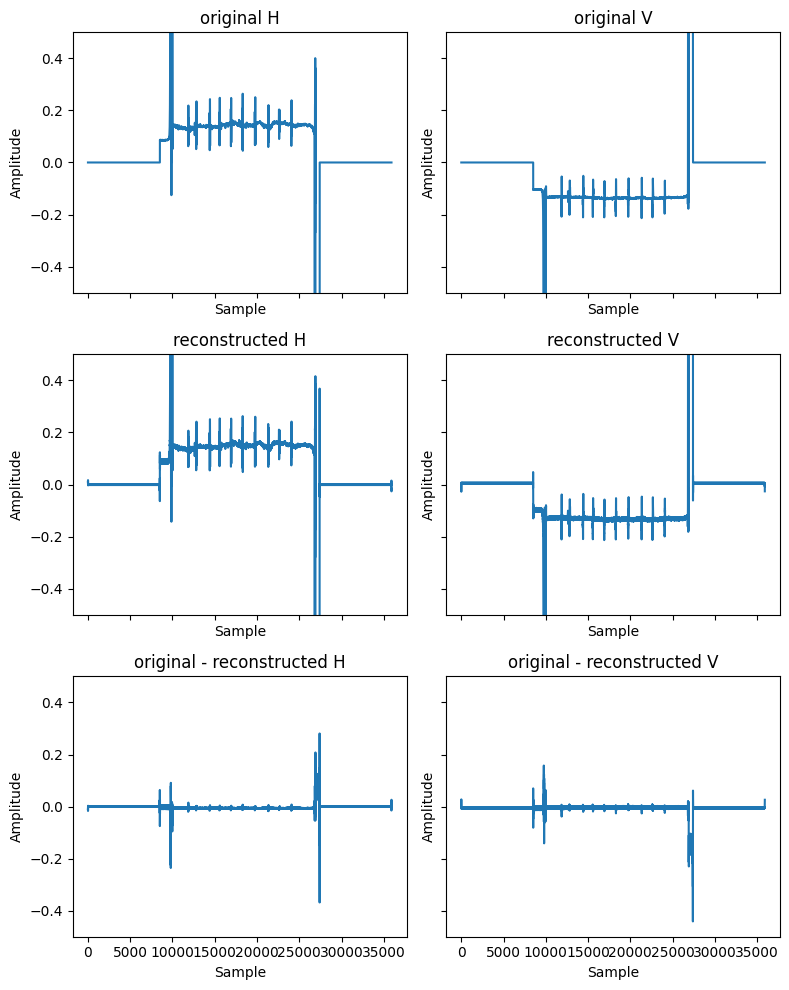

In [38]:
#きず有りテスト用データのプロット

fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)

ch = 2 # F1=0, F2=2, F3=4, MIX=6
H = ch 
V = ch+1
n = 1


# 上段左のサブプロットにプロットする
axes[0,0].plot(reshaped_test_sensor_data[n,:,H])
axes[0,0].set_title('original H')
axes[0,0].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[0,0].set_xlabel('Sample')  # x軸ラベルの追加
plt.ylim(-0.50,0.50)
# 中段左のサブプロットにプロットする
axes[1,0].plot(reconstructed_test_data[n,:,H])
axes[1,0].set_title('reconstructed H')
axes[1,0].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[1,0].set_xlabel('Sample')  # x軸ラベルの追加
# 下段左のサブプロットにプロットする
axes[2,0].plot(reshaped_test_sensor_data[n,:,H]-reconstructed_test_data[n,:,H])
axes[2,0].set_title('original - reconstructed H')
axes[2,0].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[2,0].set_xlabel('Sample')  # x軸ラベルの追加
# 上段右のサブプロットにプロットする
axes[0,1].plot(reshaped_test_sensor_data[n,:,V])
axes[0,1].set_title('original V')
axes[0,1].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[0,1].set_xlabel('Sample')  # x軸ラベルの追加
# 中段右のサブプロットにプロットする
axes[1,1].plot(reconstructed_test_data[n,:,V])
axes[1,1].set_title('reconstructed V')
axes[1,1].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[1,1].set_xlabel('Sample')  # x軸ラベルの追加
# 下段右のサブプロットにプロットする
axes[2,1].plot(reshaped_test_sensor_data[n,:,V]-reconstructed_test_data[n,:,V])
axes[2,1].set_title('original - reconstructed V')
axes[2,1].set_ylabel('Amplitude')  # y軸ラベルの追加
axes[2,1].set_xlabel('Sample')  # x軸ラベルの追加
# グラフのレイアウトを整える
plt.tight_layout()

# グラフを表示する
plt.show()

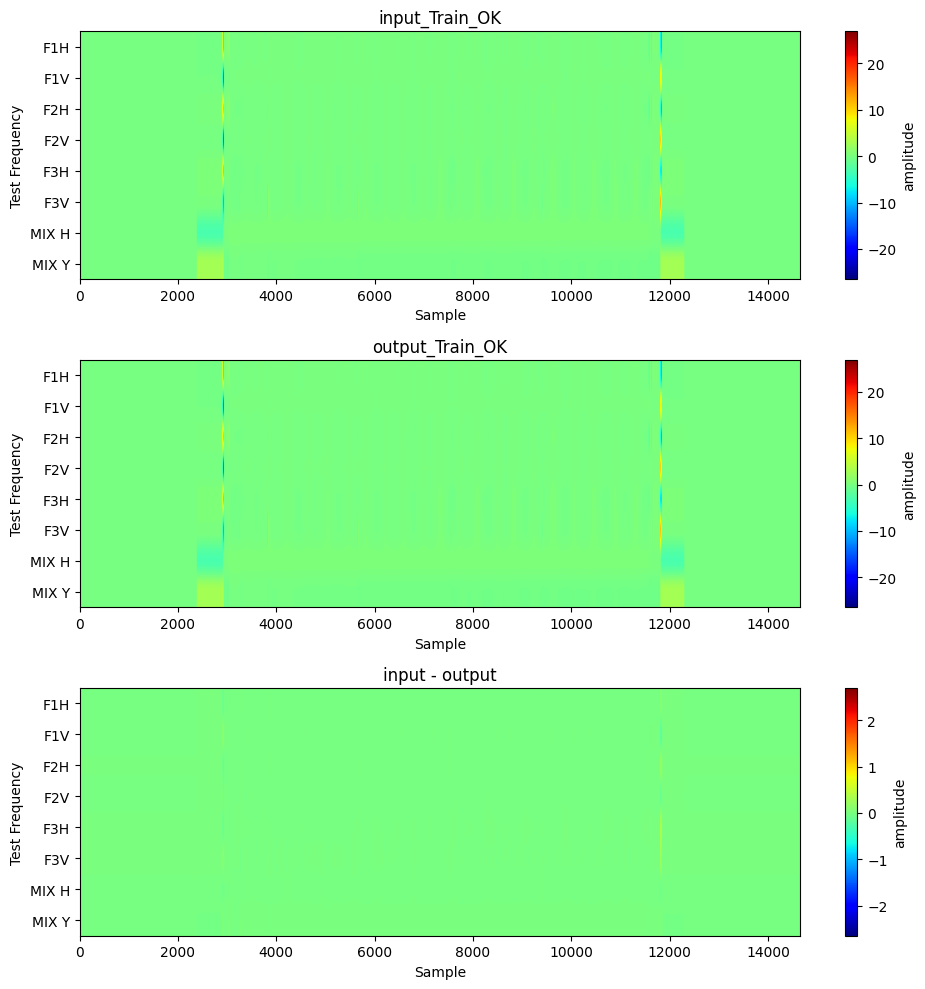

In [77]:
#　各管のデータを色調表示する。
import matplotlib.pyplot as plt
n = 1
# カラースケールの最小値と最大値を設定
vmin = min(np.min(reshaped_sensor_data[n,:,:]), np.min(reconstructed_data[n,:,:]))
vmax = max(np.max(reshaped_sensor_data[n,:,:]), np.max(reconstructed_data[n,:,:]))

plt.figure(figsize=(10, 10))

# input_Train_OK
plt.subplot(311)
plt.imshow(reshaped_sensor_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('input_Train_OK')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# output_Train_OK
plt.subplot(312)
plt.imshow(reconstructed_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('output_Train_OK')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# input - output
plt.subplot(313)
plt.imshow((reshaped_sensor_data[n,:,:] - reconstructed_data[n,:,:]).T, cmap='jet', aspect='auto', vmin=vmin/10, vmax=vmax/10)
plt.colorbar(label='amplitude')
plt.title('input - output')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

plt.tight_layout()
plt.show()


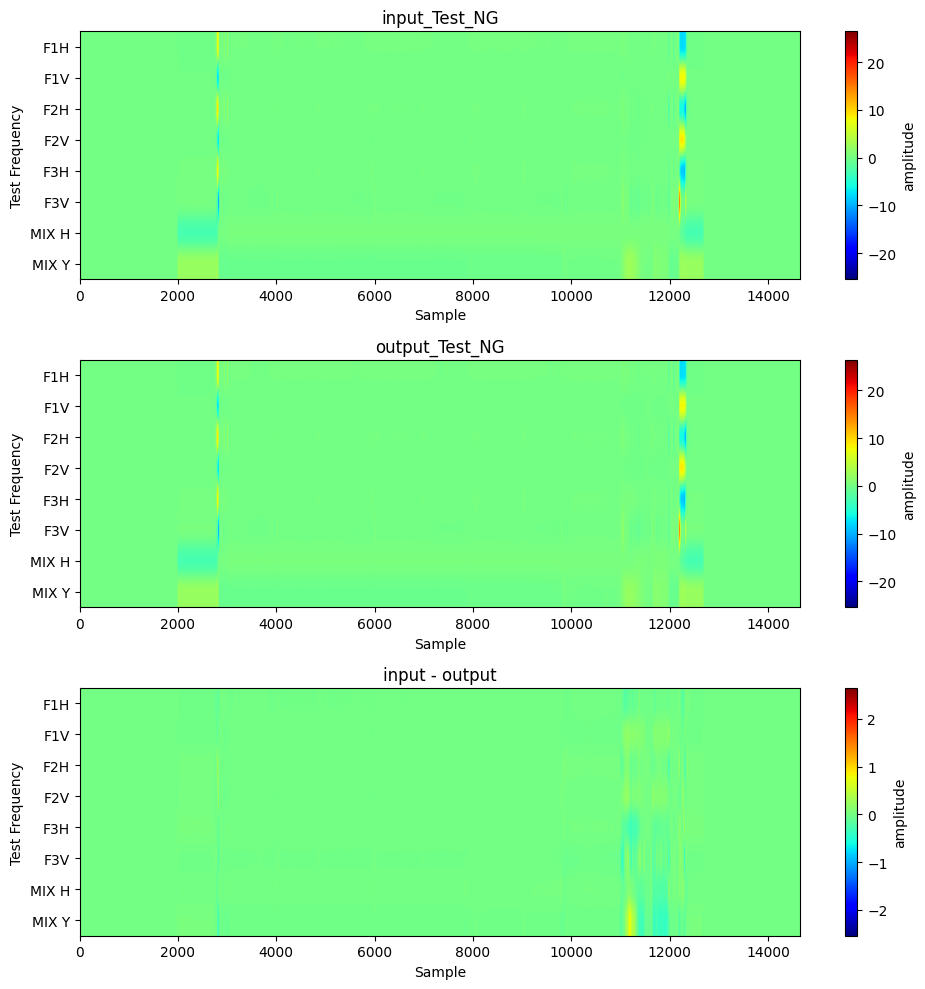

In [63]:
#　各管のデータを色調表示する。
n = 9
# カラースケールの最小値と最大値を設定
vmin = min(np.min(reshaped_sensor_data[n,:,:]), np.min(reconstructed_data[n,:,:]))
vmax = max(np.max(reshaped_sensor_data[n,:,:]), np.max(reconstructed_data[n,:,:]))

plt.figure(figsize=(10, 10))

# input_Train_OK
plt.subplot(311)
plt.imshow(reshaped_test_sensor_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('input_Test_NG')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# output_Train_OK
plt.subplot(312)
plt.imshow(reconstructed_test_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('output_Test_NG')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# input - output
plt.subplot(313)
plt.imshow((reshaped_test_sensor_data[n,:,:] - reconstructed_test_data[n,:,:]).T, cmap='jet', aspect='auto', vmin=vmin/10, vmax=vmax/10)
plt.colorbar(label='amplitude')
plt.title('input - output')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

plt.tight_layout()
plt.show()

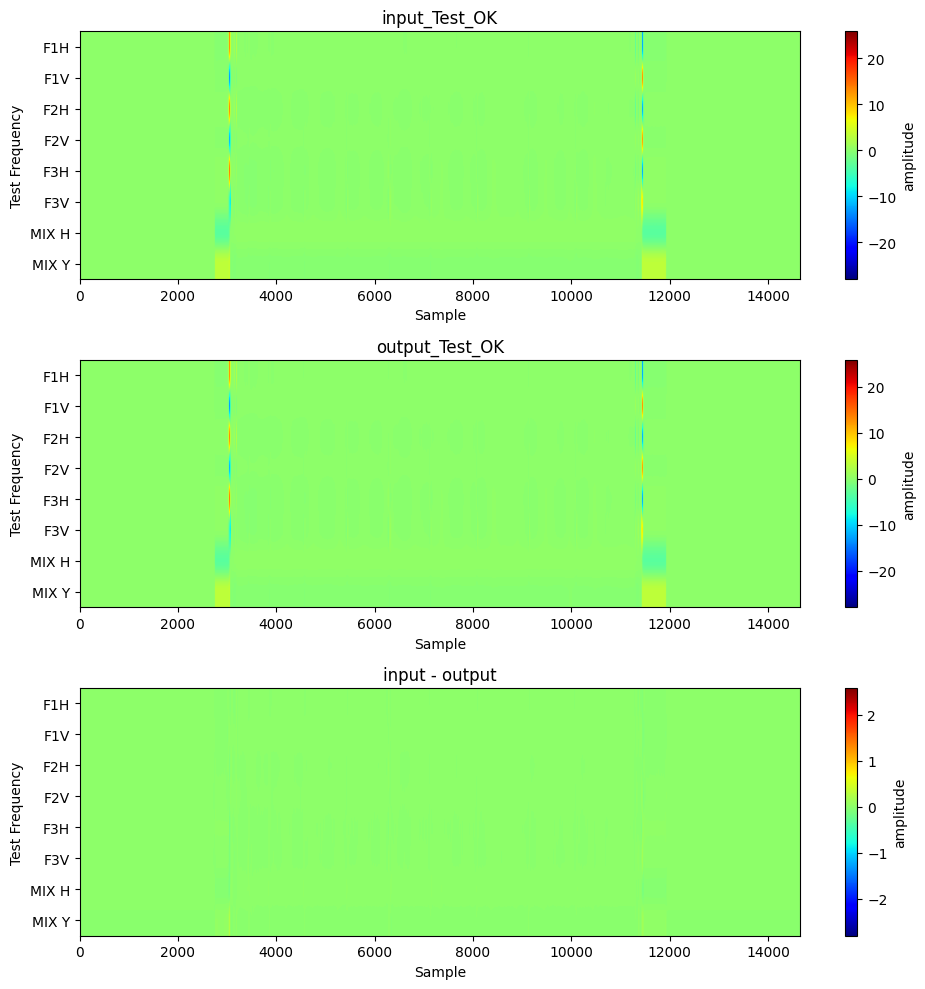

In [62]:
#　各管のデータを色調表示する。
n = 20
# カラースケールの最小値と最大値を設定
vmin = min(np.min(reshaped_sensor_data[n,:,:]), np.min(reconstructed_data[n,:,:]))
vmax = max(np.max(reshaped_sensor_data[n,:,:]), np.max(reconstructed_data[n,:,:]))

plt.figure(figsize=(10, 10))

# input_Train_OK
plt.subplot(311)
plt.imshow(reshaped_val_sensor_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('input_Test_OK')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# output_Train_OK
plt.subplot(312)
plt.imshow(reconstructed_val_data[n,:,:].T, cmap='jet', aspect='auto', vmin=vmin, vmax=vmax)
plt.colorbar(label='amplitude')
plt.title('output_Test_OK')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])

# input - output
plt.subplot(313)
plt.imshow((reshaped_val_sensor_data[n,:,:] - reconstructed_val_data[n,:,:]).T, cmap='jet', aspect='auto', vmin=vmin/10, vmax=vmax/10)
plt.colorbar(label='amplitude')
plt.title('input - output')
plt.xlabel('Sample')
plt.ylabel('Test Frequency')
plt.yticks([0, 1, 2, 3, 4, 5, 6, 7], ['F1H', 'F1V', 'F2H', 'F2V', 'F3H', 'F3V', 'MIX H', 'MIX Y'])
plt.tight_layout()
plt.show()

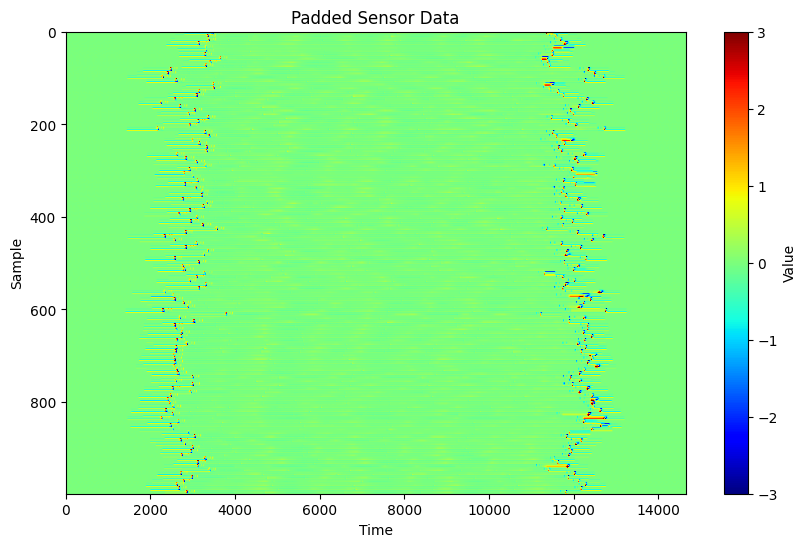

In [64]:
plt.figure(figsize=(10, 6))
plt.imshow(padded_sensor_data[1001:2000], aspect='auto', cmap='jet', vmin=-3, vmax=3)
plt.colorbar(label='Value')
plt.xlabel('Time')
plt.ylabel('Sample')
plt.title('Padded Sensor Data')
plt.show()

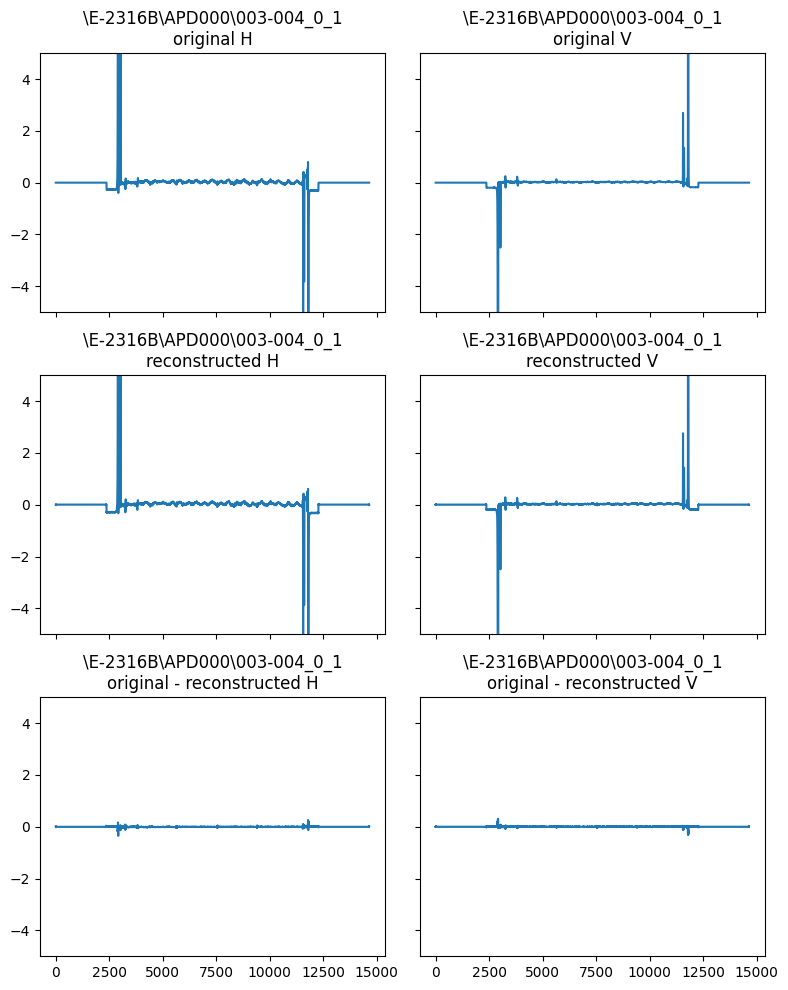

In [107]:
# Figureを作成し、2つのサブプロットを配置する
fig, axes = plt.subplots(3, 2, figsize=(8, 10), sharex=True, sharey=True)

ch = 0 # F1=0, F2=2, F3=4, MIX=6
H = ch 
V = ch+1
n = 1

# オリジナルのセンサーデータのキーを取得
data_key = list(sensor_data_dict.keys())[n*8]
# キーから重要な情報を抜き出す（例: データの種類や位置）
info = data_key.split('ASSORT')[1]

# 上段左のサブプロットにプロットする
axes[0,0].plot(reshaped_sensor_data[n,:,H])
axes[0,0].set_title(f'{info}\noriginal H')
plt.ylim(-5,5)
# 中段左のサブプロットにプロットする
axes[1,0].plot(reconstructed_data[n,:,H])
axes[1,0].set_title(f'{info}\nreconstructed H')
# 下段左のサブプロットにプロットする
axes[2,0].plot(reshaped_sensor_data[n,:,H]-reconstructed_data[n,:,H])
axes[2,0].set_title(f'{info}\noriginal - reconstructed H')

# 上段右のサブプロットにプロットする
axes[0,1].plot(reshaped_sensor_data[n,:,V])
axes[0,1].set_title(f'{info}\noriginal V')
# 中段右のサブプロットにプロットする
axes[1,1].plot(reconstructed_data[n,:,V])
axes[1,1].set_title(f'{info}\nreconstructed V')
# 下段右のサブプロットにプロットする
axes[2,1].plot(reshaped_sensor_data[n,:,V]-reconstructed_data[n,:,V])
axes[2,1].set_title(f'{info}\noriginal - reconstructed V')

# グラフのレイアウトを整える
plt.tight_layout()

# グラフを表示する
plt.show()


In [78]:
whos

Variable                               Type          Data/Info
--------------------------------------------------------------
Adam                                   type          <class 'keras.optimizers.optimizer_v2.adam.Adam'>
Conv1D                                 type          <class 'keras.layers.conv<...>olutional.conv1d.Conv1D'>
Conv1DTranspose                        type          <class 'keras.layers.conv<...>anspose.Conv1DTranspose'>
H                                      int           6
Input                                  function      <function Input at 0x0000021B10522200>
MaxPooling1D                           type          <class 'keras.layers.pool<...>_pooling1d.MaxPooling1D'>
Model                                  type          <class 'keras.engine.training.Model'>
UpSampling1D                           type          <class 'keras.layers.resh<...>sampling1d.UpSampling1D'>
V                                      int           7
ZeroPadding1D                          typ

In [94]:
data_key = list(sensor_data_dict.keys())[]
print(data_key)

C:/Users/r-fujita/Desktop/20240307/train\FCC_E-2316B\2019\#1\ASSORT\E-2316B\APD000\003-004_0_1
